In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# dependecy depreciation
np.float = float    
np.int = int  
np.object = object   
np.bool = bool

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import CLA



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## 1. Portfolio Risk and Return

### 1.1 Portfolio Returns during crisis

In [2]:
portfolio = pd.read_csv("crisis_portfolio.csv", index_col='Date')
portfolio.index = pd.to_datetime(portfolio.index,format = '%d/%m/%Y')
print(portfolio.head())

returns = portfolio.pct_change()
weights = [0.25, 0.25, 0.25, 0.25]
portfolio_returns = returns.dot(weights)

              Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Date                                                              
2004-12-31  481.799988       55.520000     104.040001    39.009998
2005-01-03  482.700012       55.900002     104.949997    39.150002
2005-01-04  478.600006       55.299999     104.269997    38.410000
2005-01-05  484.600006       54.980000     103.800003    38.490002
2005-01-06  489.299988       56.279999     105.230003    38.709999


              Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Date                                                              
2008-02-01  296.899994       48.250000     207.779999    48.250000
2008-02-04  292.200012       48.029999     200.800003    46.220001
2008-02-05  270.500000       45.560001     189.860001    43.889999
2008-02-06  269.200012       44.950001     187.169998    43.720001
2008-02-07  267.000000       44.880001     190.460007    45.110001


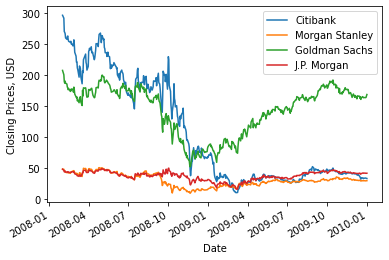

In [3]:
# Select portfolio asset prices for the middle of the crisis, 2008-2009
asset_prices = portfolio.loc['02/01/2008':'31/12/2009']
print(asset_prices.head())

# Plot portfolio's asset prices during this time
asset_prices.plot().set_ylabel("Closing Prices, USD")
plt.show()

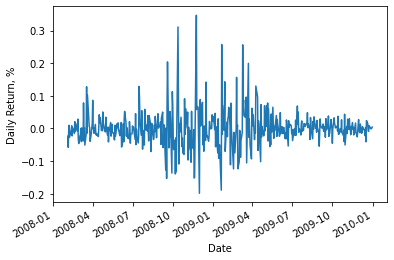

In [4]:
# Compute the portfolio's daily returns
asset_returns = asset_prices.pct_change()
portfolio_returns_crisis = asset_returns.dot(weights)

# Plot portfolio returns
portfolio_returns_crisis.plot().set_ylabel("Daily Return, %")
plt.show()

### 1.2 Asset Covariance during crisis

In [5]:
# Generate the covariance matrix from portfolio asset's returns
covariance = asset_returns.cov()

# Scale covariance annually
covariance = covariance * 252

print(covariance)

                Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Citibank        1.526224        0.850605       0.590932     0.745771
Morgan Stanley  0.850605        1.343898       0.681356     0.575239
Goldman Sachs   0.590932        0.681356       0.515569     0.437167
J.P. Morgan     0.745771        0.575239       0.437167     0.699362


### 1.3 Portfolio Volatility during crisis

In [6]:
# Portfolio volatility for 2008 to 2009
portfolio_variance = np.transpose(weights) @ covariance @ weights
portfolio_volatility = np.sqrt(portfolio_variance)
print(portfolio_volatility)

0.8604938970533907


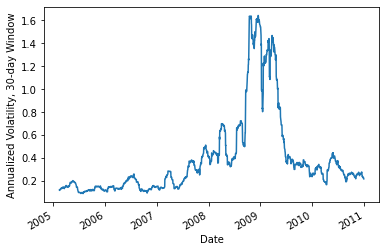

In [7]:
# 30-day rolling window of portfolio returns
returns_windowed = portfolio_returns.rolling(30)

# Annualize volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)

# Plot the portfolio volatility
volatility_series.plot().set_ylabel("Annualized Volatility, 30-day Window")
plt.show()

### 1.4 Risk Factor Correlation
We will be using quarterly mortgage delinquency rates from 2005 to 2009 to compare with the portfolio returns

In [8]:
mort_del = pd.read_csv("mortgage_delinquency.csv", index_col='Date')
mort_del.head()

,Mortgage Delinquency Rate
Date,
2005-03-31,0.0155
2005-06-30,0.0159
2005-09-30,0.0163
2005-12-31,0.0161
2006-03-31,0.0162


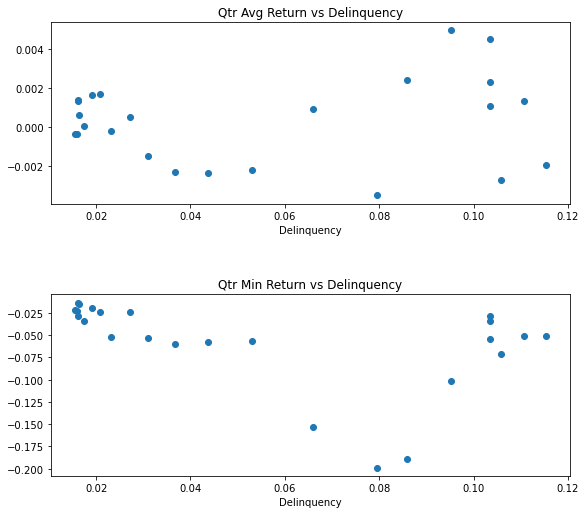

In [9]:
# Convert daily portfolio_returns into quarterly avg and min returns
portfolio_q_average = portfolio_returns.resample('Q').mean().dropna()
portfolio_q_min = portfolio_returns.resample('Q').min().dropna()

# Plot relationship of quarterly avg and min with delinquency rates
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(9)

ax1.set_title('Qtr Avg Return vs Delinquency')
ax1.scatter(mort_del, portfolio_q_average)
ax1.set_xlabel('Delinquency')

ax2.set_title('Qtr Min Return vs Delinquency')
ax2.scatter(mort_del, portfolio_q_min)
ax2.set_xlabel('Delinquency')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0, 
                    hspace=0.5)
plt.show()

The plots suggest there is weak correlation between average returns and deliquency rates. But there looks to be negative correlation between minimum returns and deliquency rates

### 1.5 Efficient Frontier
Here we will calculate thee efficient frontier to visualize the risk-return tradeoffs of portfolios. We will investigate the efficient frontiers throughout 3 subperiods (before, during, and after crisis)

Periods are 2005-2006 (before), 2007-2008 (during), 2009-2010 (after)

##### Step 1 - segregate periods between 2005 to 2010 and get expected returns and covariance matrix for each period

In [32]:
# Create a dictionary of time periods 
epochs = { 'before' : {'start': '1-1-2005', 'end': '31-12-2006'},
           'during' : {'start': '1-1-2007', 'end': '31-12-2008'},
           'after'  : {'start': '1-1-2009', 'end': '31-12-2010'}
         }

# Compute the expected returns and efficient covariance for each epoch
e_exp = {}
e_cov = {}
for x in epochs.keys():
  sub_price = portfolio.loc[epochs[x]['start']:epochs[x]['end']]
  e_exp[x] = mean_historical_return(sub_price, frequency=252)
  e_cov[x] = CovarianceShrinkage(sub_price).ledoit_wolf()

# Display the efficient covariance matrices for all epochs
print("Expected Returns\n", e_exp)
print("Efficient Covariance Matrices\n", e_cov)

Expected Returns
 {'before': Citibank          0.074516
Morgan Stanley    0.207847
Goldman Sachs     0.379977
J.P. Morgan       0.111193
dtype: float64, 'during': Citibank         -0.652236
Morgan Stanley   -0.557410
Goldman Sachs    -0.352148
J.P. Morgan      -0.190451
dtype: float64, 'after': Citibank         -0.184163
Morgan Stanley    0.269505
Goldman Sachs     0.391871
J.P. Morgan       0.161314
dtype: float64}
Efficient Covariance Matrices
 {'before':                 Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Citibank        0.018149        0.013789       0.013183     0.013523
Morgan Stanley  0.013789        0.043021       0.030559     0.016525
Goldman Sachs   0.013183        0.030559       0.044482     0.018237
J.P. Morgan     0.013523        0.016525       0.018237     0.024182, 'during':                 Citibank  Morgan Stanley  Goldman Sachs  J.P. Morgan
Citibank        0.713035        0.465336       0.323977     0.364848
Morgan Stanley  0.465336        0.994390    

##### Step 2 - gather efficient frontier for each period

In [33]:
# Initialize the Crtical Line Algorithm object
efficient_portfolio_before = CLA(e_exp['before'], e_cov['before'])
efficient_portfolio_during = CLA(e_exp['during'], e_cov['during'])
efficient_portfolio_after = CLA(e_exp['after'], e_cov['after'])

# Compute the efficient frontier
(ret_bef, vol_bef, weights) = efficient_portfolio_before.efficient_frontier()
(ret_dur, vol_dur, weights) = efficient_portfolio_during.efficient_frontier()
(ret_aft, vol_aft, weights) = efficient_portfolio_after.efficient_frontier()

##### Plot efficient frontiers

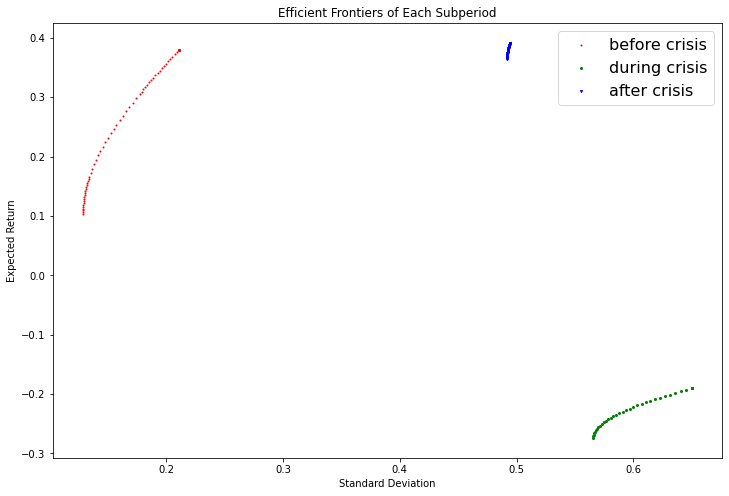

In [45]:
plt.figure(figsize=(12,8))
plt.scatter(vol_bef, ret_bef, s = 4, c = 'r', marker = '.', label = 'before crisis')
plt.scatter(vol_dur, ret_dur, s = 4, c = 'g', marker = 'o', label = 'during crisis')
plt.scatter(vol_aft, ret_aft, s = 4, c = 'b', marker = 'v', label = 'after crisis')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontiers of Each Subperiod')
plt.legend(fontsize=16)
plt.show()